# COMP1801 - Machine Learning 
## University of Greenwich
## 001002629

###### Using Classification Theory on cifar10 dataset


In [1]:
import numpy as np #  provides a multidimensional array object
import matplotlib as plt # library for visualizations, graphs
import tensorflow as tf # machine learning framework
import matplotlib.pyplot as plt # graph plotting library
from sklearn.metrics import confusion_matrix # plotting tool for confususion matrix
import itertools
import random # used to generate random numbers

In [2]:
# importing modules from tensorflow.keras to keep code readable
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
print(tf.__version__)

2.2.0


### Varaibles

In [4]:
### Variables
PATH = "/home/michael/DataSciMSc/comp1801/coursework"
MODEL_NAME = "007_6Conv_2Dense500_SGD_DG"

# used for the dataset to change the numerical system
labels = '''airplane
automobile
bird
cat
dear
dog
frog
horse
ship
truck'''.split()


### Hyperparameters

In [5]:
USE_DATA_GENERATOR = True # use data augmentation or not
BATCH_SIZE = 32 # batch size
EPOCS = 50 # number of epochs
ACTIVATION_LAYER = "relu"
ACTIVATION_OUTPUT = "softmax"
OPTIMIZER = "sgd"
LOSS = "sparse_categorical_crossentropy"

#### Creating directories

In [6]:
# creating directories for images and models to be saved
import os

if not os.path.exists('%s/Model_Data/%s' %(PATH, MODEL_NAME)):
    os.makedirs('%s/Model_Data/%s' %(PATH, MODEL_NAME))
    print("***\nNew model directory created\n***")
else:
    print("***\nModel directory already present\n***")

***
New model directory created
***


## Functions that are used throughout the program

In [7]:
# function takes numpy array and checks unique element count, returns array
def count_freq(numpy_data):
    (unique, counts) = np.unique(numpy_data, return_counts=True)
    frequencies = np.asarray((unique, counts)).T   # hold the frequency of each value
    return frequencies

In [8]:
# function to print out values for dataset
def array_values(image_array, labal_array, data_set):
    print("%s Image values:" % data_set)
    print('Image values (min to max):', np.min(image_array), 'to', np.max(image_array))
    if(data_set == "Training"):
        data = "train"
    else:
        data = "test"
    print("X_{0} shape: {1}".format(data, image_array.shape))
    print("y_{0} shape: {1}".format(data, labal_array.shape))
    test_freq = count_freq(labal_array)
    print("{0} dataset split: {1}".format(data, test_freq)) 

In [9]:
# function used to normalize arrays to values between 0 and 1
def normalise_data(array):
    output = array.astype("float32") / 255
    return output

In [10]:
# function to flatten arrays
def flatten_data(array):
    output = array.flatten()
    return output

In [11]:
# function takes numpy array and checks unique element count, returns array
def count_freq(numpy_data):
    (unique, counts) = np.unique(numpy_data, return_counts=True)
    frequencies = np.asarray((unique, counts)).T   # hold the frequency of each value
    return frequencies    

In [12]:
# function takes in numpy array and string, output bar graphs showing 
# distribution of training and testing data
def plot_freq(frequency, title):
    #labels = frequency[:,0] # labels for x axis
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1]) # axes is absolute coordinates on plot
    
    ax.bar(frequency[0:10, 0],frequency[0:10, 1]) # x and y axis for plot
    plt.xticks(frequency[0:10, 0], labels, rotation = 45) # define the x labels
    plt.title(title) # title
    plt.xlabel("Class") # x axis label
    plt.ylabel("Number of images")# y axis label
    # loop to get frequency data and display on chart
    for index,data in enumerate(frequency[0:10, 1]):
        # position the text data 
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10),ha="center")
    if not os.path.exists("%s/Model_Data/%s.png"% (PATH,title)):
        plt.savefig("%s/Model_Data/%s.png"% (PATH,title))

In [13]:
# plot history graphs from model training
def plot_history_graphs(data1, data2):
    plt.plot(history.history[data1], label = data1)
    plt.plot(history.history[data2], label = data2)
    plt.grid(True)
    plt.tight_layout()
    plt.title('Model %s'%data1)
    plt.ylabel(data1)
    plt.xlabel("Epoch")
    plt.legend()
    if not os.path.exists("%s/Model_Data/%s/%s.png"% (PATH,MODEL_NAME,data1)):
        plt.savefig("%s/Model_Data/%s/%s.png"% (PATH,MODEL_NAME,data1))

In [14]:
# function to plot random images from the dataset
def image_plot(Image_array, Label_array, Cols, Classes = 10, title = "Data Visulisation"):
    image_array = Image_array # image array
    label_array = Label_array # label array
    cols = Cols # number of columns for visulisation
    num_classes = Classes # classes 
    num_of_samples = [] # empty list
 
    # figure formatting
    fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(cols,num_classes))
    fig.tight_layout()

    # nested for loops to generate multiple images from data set
    for i in range(cols):
        for j in range(num_classes):
          x_selected = image_array[label_array == j]
          axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
          axs[j][i].axis("off")
          if i == 2:
            axs[j][i].set_title(str(j))
            num_of_samples.append(x_selected)
    if not os.path.exists("%s/Images/%s.png"% (PATH,title)):
        plt.savefig("%s/Images/%s.png"% (PATH,title))

In [15]:
# plot a confusion matrix to see what is going on with 
# model prediction
def confusion_matrix_graph(cm, classes,
                    title = "Confusion Matrix",
                    cmap = plt.cm.Blues):
    
    #cm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], "d"),
        horizontalalignment = "center",
        color = "white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    if not os.path.exists("%s/Model_Data/%s/%s.png"% (PATH,MODEL_NAME,title)):
        plt.savefig("%s/Model_Data/%s/%s.png"% (PATH,MODEL_NAME,title))
    

### Load in cifar10 dataset

In [16]:
# load in data from keras datasets
cifar10_data = tf.keras.datasets.cifar10
# assign data to variables
(X_train_raw, y_train_raw), (x_test_raw, y_test_raw) = cifar10_data.load_data()

In [17]:
# nomalise image data
X_train = normalise_data(X_train_raw)
x_test = normalise_data(x_test_raw)

In [18]:
# flatten label data
y_train = flatten_data(y_train_raw)
y_test = flatten_data(y_test_raw)

In [19]:
# check values of the training reshaped/nomalised arrays
array_values(X_train, y_train, "Training")   

Training Image values:
Image values (min to max): 0.0 to 1.0
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000,)
train dataset split: [[   0 5000]
 [   1 5000]
 [   2 5000]
 [   3 5000]
 [   4 5000]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 5000]]


In [20]:
# check values for the testing reshaped/normalised arrays
array_values(x_test, y_test, "Testing")

Testing Image values:
Image values (min to max): 0.0 to 1.0
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000,)
test dataset split: [[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]


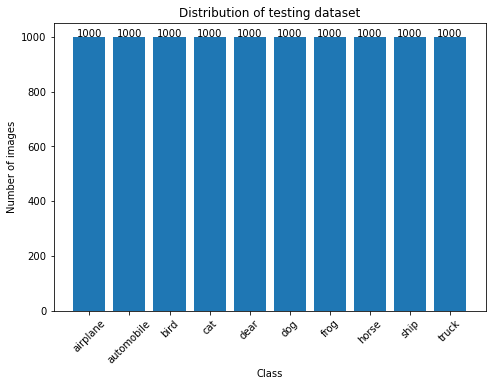

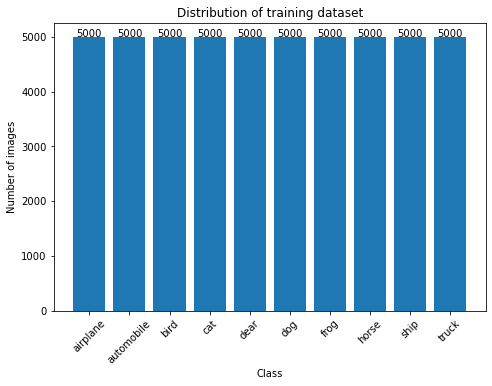

In [21]:
# testing data frequency
ax = plot_freq(count_freq(y_test), "Distribution of testing dataset")    

# training data frequency
ax2 = plot_freq(count_freq(y_train), "Distribution of training dataset")    
plt.show()


In [22]:
number_of_classes = len(set(y_train))
print("Number of classes: ", number_of_classes)

Number of classes:  10


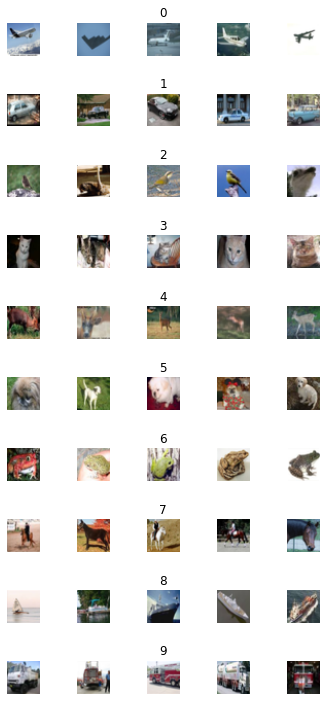

In [23]:
# visualise the dataset
image_plot(X_train,y_train, 5)

### Build tensorflow model using API method

In [24]:
# build model using tensorflow functional API
# first filter size = 3 * 3 * 3 * 32
first_layer = Input(shape = X_train[0].shape)

x = Conv2D(32, (3,3),  activation = ACTIVATION_LAYER, padding = "same")(first_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(500, activation = ACTIVATION_LAYER)(x)
x = Dropout(0.2)(x)
x = Dense(number_of_classes, activation=ACTIVATION_OUTPUT)(x)

In [25]:
model = Model(first_layer, x)

In [26]:
model.compile(optimizer = OPTIMIZER,
              loss = LOSS,
              metrics = ("accuracy")
             )

In [27]:
from contextlib import redirect_stdout
if not os.path.exists('%s/Model_Data/%s/modelsummary.txt' %(PATH, MODEL_NAME)):
    with open('%s/Model_Data/%s/modelsummary.txt' %(PATH, MODEL_NAME), 'w') as f:
        with redirect_stdout(f):
            model.summary()
            print("Summary Written.")
else:
    print("Summary already saved.")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496 

In [28]:
## preprocess data on the fly using keras ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range = 90, # Int. Degree range for random rotations.
    width_shift_range = 0.1, #float: fraction of total width, if < 1, or pixels if >= 1.
    height_shift_range = 0.1,
    horizontal_flip = True #Boolean. Randomly flip inputs horizontally.
    )

In [29]:
# calculate the number of steps while generating data to iterate over entire dataset
# using floor division
STEPS_PER_EPOC = X_train.shape[0] // BATCH_SIZE
# call to data generator
train_generator = data_generator.flow(X_train,y_train, BATCH_SIZE)

In [30]:
# fit model

if(USE_DATA_GENERATOR == True):
    history = model.fit(train_generator, 
                                  steps_per_epoch = STEPS_PER_EPOC, 
                                  epochs = EPOCS,
                                  validation_data =(x_test, y_test),
                                   shuffle=True)
else:
    history = model.fit(X_train, y_train,
                        validation_data =(x_test, y_test),
                        epochs = EPOCS,
                           shuffle=True)

Epoch 1/50
1562/1562 [==============================] - 19s 12ms/step - loss: 1.8524 - accuracy: 0.3457 - val_loss: 1.7171 - val_accuracy: 0.3846
Epoch 2/50
1562/1562 [==============================] - 19s 12ms/step - loss: 1.5663 - accuracy: 0.4365 - val_loss: 1.4667 - val_accuracy: 0.4740
Epoch 3/50
1562/1562 [==============================] - 19s 12ms/step - loss: 1.4437 - accuracy: 0.4793 - val_loss: 1.4114 - val_accuracy: 0.4991
Epoch 4/50
1562/1562 [==============================] - 19s 12ms/step - loss: 1.3531 - accuracy: 0.5142 - val_loss: 1.2628 - val_accuracy: 0.5439
Epoch 5/50
1562/1562 [==============================] - 19s 12ms/step - loss: 1.2757 - accuracy: 0.5410 - val_loss: 1.4405 - val_accuracy: 0.4930
Epoch 6/50
1562/1562 [==============================] - 19s 12ms/step - loss: 1.2123 - accuracy: 0.5648 - val_loss: 1.2107 - val_accuracy: 0.5675
Epoch 7/50
1562/1562 [==============================] - 19s 12ms/step - loss: 1.1723 - accuracy: 0.5807 - val_loss: 1.2431 -

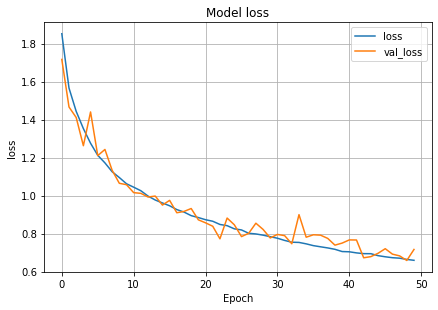

In [31]:
val_loss = plot_history_graphs("loss", "val_loss")


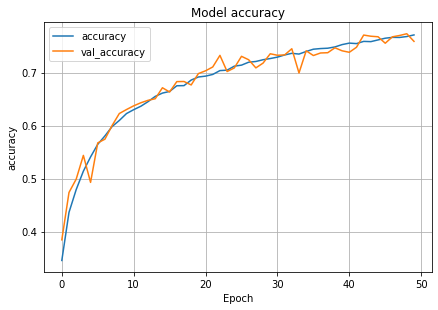

In [32]:
val_accuracy = plot_history_graphs("accuracy", "val_accuracy")


In [33]:
score = model.evaluate(x_test, y_test, verbose=0)
score_output = print('Test loss: %s \nTest accuracy: %s' % (score[0], score[1]))

if not os.path.exists('%s/Model_Data/%s/evaluation_score.txt' %(PATH, MODEL_NAME)):
    with open('%s/Model_Data/%s/evaluation_score.txt' %(PATH, MODEL_NAME), 'w') as f:
        with redirect_stdout(f):
            print('Test loss: %s \nTest accuracy: %s' % (score[0], score[1]))
    print("Score Written.")
else:
    print("Score Already present")
score_output
 


Test loss: 0.71649569272995 
Test accuracy: 0.7590000033378601
Score Written.


In [34]:
preditctions = model.predict(x_test).argmax(axis = 1)
cm = confusion_matrix(y_test, preditctions)


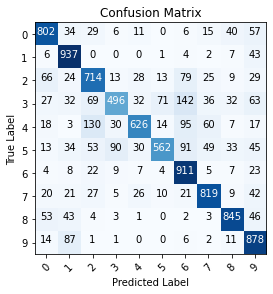

In [35]:
#print confusion matrix
confusion_matrix_graph(cm, list(range(10)))

Text(0.5, 1.0, 'True label: cat | Predicted: frog')

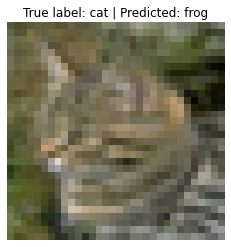

In [36]:
## display misclassified examples
misclassified = np.where(preditctions != y_test)[0]
image = np.random.choice(misclassified)
plt.imshow(x_test[image], cmap="gray")
plt.axis('off')
plt.title("True label: %s | Predicted: %s" % (labels[y_test[image]], labels[preditctions[image]]))

In [37]:
# save model weights
if not os.path.exists("%s/Model_Data/%s/%s.h5" % (PATH,MODEL_NAME,MODEL_NAME)):
        model.save_weights("%s/Model_Data/%s/%s.h5" % (PATH,MODEL_NAME,MODEL_NAME))
